# Quickstart: Amortized Posterior Estimation

## Table of Contents
 * [Introduction](#introduction)
 * [Defining the Generative Model](#defining_the_generative)
	 * [Prior](#prior)
	 * [Simulator](#simulator)
	 * [Generative Model](#generative_model)
 * [Defining the Neural Approximator](#defining_the_neural)
	 * [Summary Network](#summary_network)
	 * [Inference Network](#inference_network)
	 * [Amortized Posterior](#amortized_posterior)
 * [Defining the Trainer](#defining_the_trainer)
 * [Training Phase](#training_phase)
	 * [Online Training](#online_training)
	 * [Inspecting the Loss](#inspecting_the_loss)
	 * [Validating Consistency](#validating_consistency)
		 * [Latent space inspection](#latent_space_inspection)
		 * [Simulation-Based Calibration](#simulation_based_calibration)
		 * [Posterior z-score and contraction](#posterior_z_score_and)
 * [Inference Phase](#inference_phase)

In [6]:
import bayesflow as bf
import numpy as np

## Introduction <a class="anchor" id="introduction"></a>

Welcome to the very first tutorial on using <strong>BayesFlow</strong> for amortized posterior estimation! In this notebook, we will estimate the means of a multivariate Gaussian model and illustrate some features of the library along the way. 

Here is a brief description of amortized posterior estimation: 

In traditional posterior estimation, as in Bayesian inference, we seek to compute or approximate the posterior distribution of model parameters given observed data for each new data instance separately. This process can be computationally expensive, especially for complex models or large datasets, because it often involves iterative optimization or sampling methods. This step needs to be repeated for each new instance of data.

Amortized posterior estimation offers a solution to this problem. "Amortization" here refers to spreading out the computational cost over multiple instances. Instead of computing a new posterior from scratch for each data instance, amortized inference learns a function. This function is parameterized by a neural network, that directly maps observations to an approximation of the posterior distribution. This function is trained over the dataset to approximate the posterior for any new data instance efficiently. In this example, we will use a simple Gaussian model to illustrate the basic concepts of amortized posterior estimation.

Above, we have already imported the core entities that we will need for this notebook. In brief:

* The module `simulation` contains high-level wrappers for gluing together priors, simulators, and context generators into a single `GenerativeModel` object, which will generate all quantities of interest for a modeling scenario.
* The module `networks` contains the core neural architectures used for various tasks, e.g., an `InvariantNetwork` for realizing normalizing flows (https://paperswithcode.com/method/normalizing-flows) or a `DeepSet` for learning permutation-invariant summary representations (embeddings).
* The module `amortizers` contains high-level wrappers which connect the various networks together and instruct them about their particular goals in the inference pipeline.
* The module `trainers` contains high-level wrappers for dictating the <em>training phase</em> of an amortized posterior. Typically, the standard `Trainer` will take care of most scenarios.

The nuts and bolts of using BayesFlow for Bayesian parameter estimation have already been described in the corresponding papers:

* Radev, S. T., Mertens, U. K., Voss, A., Ardizzone, L., Köthe, U. (2020). BayesFlow: Learning complex stochastic models with invertible neural networks. *IEEE Transactions on Neural Networks and Learning Systems, 33(4)*, 1452-1466.
* Radev, S. T., Graw, F., Chen, S., Mutters, N. T., Eichel, V. M., Bärnighausen, T., & Köthe, U. (2021).
OutbreakFlow: Model-based Bayesian inference of disease outbreak dynamics with invertible neural networks and its application to the COVID-19 pandemics in Germany. *PLoS computational biology, 17(10)*, e1009472.
* Schmitt, M., Bürkner, P. C., Köthe, U., & Radev, S. T. (2021). Detecting model misspecification in amortized Bayesian inference with neural networks. *arXiv preprint arXiv:2112.08866*.

At a high level, our architecture consists of a summary network $h$ and an inference network $f$ which jointly amortize a generative model. 
The summary network transforms input data $\boldsymbol{x}$ of potentially variable size to a fixed-length representations.
The inference network generates random draws from an approximate posterior $q$ via a conditional invertible neural network (cINN). 
This process is illustrated in the figure below:

<img src=img/bayesflow_overview.png width=90%>

The left panel illustrates the <em>training phase</em>. During this phase, only the model (i.e., simulator and prior) is used to jointly train the summary and inference networks. A parameter vector $\theta$ is sampled from the prior distribution and then fed to the simulator. The simulator returns $N$ counts of $x$ vectors that serve as input to the summary network. The right panel illustrates the <em>inference phase</em>. During this phase, arbitrarily many actually observed data sets can be fed through the networks to obtain posteriors.
For instance, in one recent paper (https://www.nature.com/articles/s41562-021-01282-7), the authors applied pre-trained networks to more than one million observed data sets! Now let's get into some coding...

First and foremost, we set a local seed for reproducibility (best `numpy` practice as of 2022). See (https://numpy.org/neps/nep-0019-rng-policy.html) for more details.

In [7]:
RNG = np.random.default_rng(2023)

## Defining the Generative Model <a class="anchor" id="defining_the_generative"></a>
From the perspective of the BayesFlow framework, a generative model is more than just a prior (encoding beliefs about the parameters before observing data) and a simulator (a likelihood function, often implicit, that generates data given parameters). In addition, it consists of various <em>implicit</em> context assumptions, which we can make <em>explicit</em> at any time. Furthermore, we can also <em>amortize</em> over these context variables, thus making our real-world inference more flexible (i.e., applicable to more contexts). We are leveraging the concept of amortized inference and extending it to context variables as well. The figure below illustrates the skeleton of a generative model as conceptualized in the BayesFlow framework.

<img src=img/generative_model.png width=75%>

This conceptual model allows you to tackle very flexible model families with BayesFlow, as well as various other Bayesian tasks, such as prior sensitivity analysis or multiverse analysis.

Prior sensitivity analysis: it is a technique used in Bayesian statistics to assess how sensitive the results of a model are to the choice of the prior distribution. In Bayesian inference, the prior represents our existing knowledge or assumptions about the parameters before observing the data. However, the selection of an appropriate prior can sometimes be subjective, and different priors can lead to different posterior estimates. Prior sensitivity analysis involves systematically varying the priors and examining how these variations affect the posterior estimates.

The toy Gaussian model we will use for this tutorial takes a particularly simple form:

$$
\begin{align}
 \boldsymbol{\mu} &\sim \mathcal{N}_D(\boldsymbol{0}, \sigma_0\mathbb{I}) \\
 \boldsymbol{x}_n &\sim \mathcal{N}_D(\boldsymbol{\mu}, \sigma_1\mathbb{I})\quad\textrm{ for } n = 1,..,N,
\end{align}
$$

where $\mathcal{N}_D$ denotes a multivariate Gaussian (normal) density with $D$ dimensions, which we set at $D = 4$ for the current example. For simplicity, we will also set $\sigma_0 =1$ and $\sigma_1 = 1$. We will now implement this model using the latest numpy interface. 

### Prior <a class="anchor" id="prior"></a>
We first define a function generating single draws from the prior (as specified by our model formulation above), which we pass to the ``Prior`` wrapper.

In [8]:
def prior_fun(D=4):
    return RNG.normal(size=D)

In [9]:
prior = bf.simulation.Prior(prior_fun=prior_fun)

That's it. The ``Prior`` object is now callable with a ``batch_size`` argument which dictates how many draws are generated from the prior. We can take a look at the outputs of the prior by doing:

In [10]:
prior(batch_size=10)

{'prior_draws': array([[ 0.60172129,  1.15161897, -1.35946236,  0.22205533],
        [-0.77586755,  0.8087058 , -0.19862826, -1.57869386],
        [-0.6292893 , -0.38775694,  0.05018619, -0.90704364],
        [ 0.13213809,  1.40490249,  0.40410205, -1.03741343],
        [-0.74180264,  1.26349944, -0.68932403,  0.70801477],
        [-0.03504752, -0.83781649, -0.73251795,  1.04738251],
        [-1.4238012 ,  1.35404102, -0.39509257, -0.92921568],
        [ 0.44406269,  0.14221762,  1.36874071, -0.49876242],
        [-0.0742687 ,  0.93937197, -0.62614275, -1.02895874],
        [-2.13303915,  0.90438789, -2.08440387,  0.28253568]]),
 'batchable_context': None,
 'non_batchable_context': None}

Wow! The prior generated some other stuff that we never specified and packed it into a Python ``dict``. That definitely needs some explanation. Remember our picture above? A prior can also accept context variables which modify its behavior, whenever this is desirable. We will see this when we illustrate how to perform <em>prior sensitivity</em> analysis.
We also see two types of context variables. These are worth mentioning as well.
 The interface distinguishes between two types of context: ``batchable_context`` and ``non_batchable_context``. This distinction is a purely technical, rather then a conceptual one:
* Batchable context variables differ for each simulation in each training batch of simulations;
* Non-batchable context variables stay the same for each simulation in a batch, but differ across simulated batches;

Examples for <strong>batchable</strong> context variables include experimental design variables, design matrices, etc.
Examples for <strong>non-batchable</strong> context variables include the number of observations in an experiment, positional encodings, time indices, etc. While the latter can also be considered batchable in principle, batching them would require non-Tensor (i.e., non-rectangular) data structures. When you have a variable that changes its structure or size across different batches (like varying the number of observations), it doesn't fit neatly into a rectangular tensor structure. One would need to use non-tensor data structures, which are not as efficiently processed by the hardware typically used for machine learning computations (like GPUs).

### Simulator <a class="anchor" id="simulator"></a>
In this case, our simulator function is equally simple to our prior function. We will call it a likelihood function, in correspondence with standard Bayesian terminology, and pass it to the ``Simulator`` wrapper.

In [11]:
def likelihood_fun(params, n_obs=50):
    return RNG.normal(loc=params, size=(n_obs, params.shape[0]))

In [12]:
simulator = bf.simulation.Simulator(simulator_fun=likelihood_fun)

Note, that we define our simulator function or `likelihood_fun` with two arguments. A positional argument, `params` which stands for a single random draw from the prior and a keyword argument ``n_obs`` which represents the number of observations $N$ that we will generate from the likelihood for each draw from the prior. As some point, we want to vary $N$ during training, so that the architecture can generalize to different values of $N$ during inference.

### Generative Model <a class="anchor" id="generative_model"></a>
We will now connect the prior with the likelihood (simulator) via the ``GenerativeModel`` interface:

In [13]:
model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 50, 4)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 50, 4)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


The generative model will also provide an internal consistency check and report on the tensor shapes of the different quantities output by the model. We can also manually inspect its outputs for ``batch_size = 3`` (i.e., three simulations):

In [14]:
out = model(batch_size=3)

In [15]:
print(list(out.keys()))

['prior_non_batchable_context', 'prior_batchable_context', 'prior_draws', 'sim_non_batchable_context', 'sim_batchable_context', 'sim_data']


In [16]:
print("Shape of sim_data: ", out["sim_data"].shape)

Shape of sim_data:  (3, 50, 4)


The output of the ``GenerativeModel`` is also a Python ``dict`` with even more keys than before. You should probably have an intuition what these keys represent, namely, the different types of context variables (none in this case) for prior and simulator. With this simple set-up, we can now proceed to do some posterior estimation.

## Defining the Neural Approximator <a class="anchor" id="defining_the_neural"></a>


### Summary Network <a class="anchor" id="summary_network"></a>


Since our likelihood generates data exchangeably, we need to respect the permutation invariance of the data. Exchangeability in data means that the probability distribution of a sequence of observations remains the same regardless of the order in which the observations appear. In other words, the data is permutation invariant. For that, we will use a ``DeepSet`` which does exactly that. This network will take (at least) 3D tensors of shape ``(batch_size, n_obs, D)`` and reduce them to 2D tensors of shape ``(batch_size, summary_dim)``, where ``summary_dim`` is a hyperparameter to be set by the user (you). Heuristically, this number should not be lower than the number of parameters in a model. Below, we create a permutation-invariant network with ``summary_dim = 10``:

In [17]:
summary_net = bf.networks.DeepSet(summary_dim=10)

2025-03-12 11:21:39.104073: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-12 11:21:39.104291: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Note, that the hyperparameter setting for the ``InvariantNetwork`` are all provided inside a single Python dictionary. Here, ``InvariantNetwork`` is used to learn a summary representation of data that is invariant to the permutation of its elements. It helps to inspect the outputs of the summary network manually and confirm its operation:

In [18]:
test_inp = model(batch_size=3)
summary_rep = summary_net(test_inp["sim_data"]).numpy()

print("Shape of simulated data sets: ", test_inp["sim_data"].shape)
print("Shape of summary vectors: ", summary_rep.shape)

Shape of simulated data sets:  (3, 50, 4)
Shape of summary vectors:  (3, 10)


It is these summary vectors that will enter as conditions for the inference network. Upon convergence of the simulation-based training, we can think of them as <em>learned summary statistics</em> or <em>data embeddings</em>.

### Inference Network <a class="anchor" id="inference_network"></a>
Next, we define the main workhorse of our our framework for amortized posterior inference - the conditional invertible neural network (cINN). The only mandatory hyperparameter for the ``InvertibleNetwork`` is the number of parameters we aim to estimate, in our case ``num_params = 4``. However, we can change some more, for instance set the number of coupling layers ``num_coupling_layers = 4``, which will make training a bit faster than using the default ``num_coupling_layers = 6``, but also reduce the expressiveness (performance) of our network. Naturally, we don't need a lot of expressiveness for our trivial Gaussian model, so we can proceed with ``num_coupling_layers = 4``.

The invertible inference network has the following further hyperparameters:

* `num_params` (mandatory) - The number of model parameters (eq. the dimensionality of the latent space).
* `num_coupling_layers` - The number of invertible layers. The more layers, the more powerful the network, but the slower and possibly less stable the training. Typically $6 - 10$ coupling layers should be sufficient.
* `coupling_settings` - The settings for the internal coupling layers. Typically, the defaults work well. For online training, you should switch off the default regularization as it may prevent optimal performance.
* `coupling_design` - You could try setting the design to `spline` for more superior performance on lower-dimensional problems.
* `soft_clamping` - The soft-clamping parameter. Just use the default value.
* `permutation` - Whether to use permutations before each coupling layer. Should be used by default.
* `use_act_norm` - Whether to apply activation normalization after each coupling layer (https://arxiv.org/abs/1807.03039). Works well in practice and stabilizes training. 
* `act_norm_init` - In some cases, you can perform data-dependent initialization of the `ActNorm` layers, as in https://arxiv.org/abs/1807.03039.
* `use_soft_flow` - Whether to use a SoftFlow architecture (https://arxiv.org/abs/2006.04604). Useful for degenerate distributions.
* `soft_flow_bounds` - The bounds for the varying standard deviation of `SoftFlow`'s noise. Do not touch, unless you have good reasons to.

You can glean all the defaults in the `default_settings` module. For most applications, you only need to define the `num_params` and `num_coupling_layers` hyperparameters.

Note, that we also remove the default `L2` and `dropout` regularization from the networks, as we need this only for offline learning with pre-simulated data. In the context of online learning, where the model is continuously updated with new data, regularization can be counterproductive. It can unnecessarily constrain the model, preventing it from fully adapting to the latest data. 

In [19]:
inference_net = bf.networks.InvertibleNetwork(
    num_params=4,
    num_coupling_layers=4,
    coupling_settings={
        "dense_args": dict(kernel_regularizer=None),
        "dropout": False,
    },
)

Again, we can inspect the raw outputs of the cINN by feeding it the parameter draws and corresponding data summaries. This network is slightly more involved than the summary network, as it has two mandatory inputs: ``targets`` and ``condition``. It also has two outputs: ``z`` and ``log_det_J``, which represent the latent representation of the parameters and the log of the Jacobian determinant, respectively.

In [20]:
z, log_det_J = inference_net(test_inp["prior_draws"], summary_rep)

Note about `z`: The inference network takes summary vectors as input and outputs latent vectors (`z`). The latent space is a lower-dimensional space that is assumed to capture the essential information about the parameters. It is essentially transforming the parameter space to the latent space (Gaussian in this case). 

We can inspect the shapes of the outputs as well:

In [21]:
print("Shape of latent variables:", z.numpy().shape)
print("Shape of log det Jacobian:", log_det_J.numpy().shape)

Shape of latent variables: (3, 4)
Shape of log det Jacobian: (3,)


### Amortized Posterior <a class="anchor" id="amortized_posterior"></a>
We can now connect the ``summary_net`` and the ``inference_net`` via the high-level wrapper ``AmortizedPosterior``. This wrapper knows how to compute its loss function, draw samples from the approximate posterior given new data and also compute normalized posterior densities. Normalized posterior density refers to a posterior probability distribution that has been adjusted so that its total area (or volume, in the case of multi-dimensional distributions) sums up to one. 

In [22]:
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)

## Defining the Trainer <a class="anchor" id="defining_the_trainer"></a>
The ``Trainer`` instance connects a generative model with an amortizer and enables various types of simulation-based training. Actually, it has only a single mandatory argument, ``amortizer``, which expect an ``Amortized*`` instance. However, in order to be able to perform on-the-fly simulation-based training (see below), we also need to provide the generative model. Note, that the generative model does not need to use our provided wrappers, but the keys of its dictionary output should adhere to BayesFlow's expectations. 

Note: If you want to automatically save the ``amortizer`` and related loss history, you can provide a ``checkpoint_path`` argument indicating the folder for storing the checkpoints.

In [23]:
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Actually, a ``Trainer`` instance does a little more than connect a generative model to an amortizer. It does so through the help of a ``configurator``. In our case the configurator was inferred from the type of amortizer provided, but for more involved models, you should define the configurator explicitly.

What does a configurator do? It takes the raw outputs of the generative models and turns them into something with which neural networks can work:

<img src=img/trainer_connection.png width=75%>

Let's see how this actually works by accessing the default (inferred) configurator from the ``Trainer`` instance.

In [24]:
# Simulate some data again
out = model(3)
print("Keys of simulated dict: ", list(out.keys()))

Keys of simulated dict:  ['prior_non_batchable_context', 'prior_batchable_context', 'prior_draws', 'sim_non_batchable_context', 'sim_batchable_context', 'sim_data']


In [25]:
conf_out = trainer.configurator(out)

In [26]:
print("Keys of configured dict: ", list(conf_out.keys()))

Keys of configured dict:  ['summary_conditions', 'direct_conditions', 'parameters']


The default configurator for posterior inference differentiates between three types of model outputs:
1. ``parameters`` - these are the quantities for which we want posteriors.
2. ``summary_conditions`` - these are the quantities that go through the summary network (typically the raw data).
3. ``direct_conditions`` -- these are concatenated with the outputs of the summary network and passed directly to the inference network.

In our case, ``summary_conditions`` simply correspond to the data, and ``parameters`` correspond to the prior draws, but you can imagine that more complex scenarios are possible. Let's confirm the former claims.

In [27]:
print(np.allclose(out["sim_data"], conf_out["summary_conditions"]))
print(np.allclose(out["prior_draws"], conf_out["parameters"]))

True
True


Here, we are not using direct equality, since the configurator converts `float64` numbers to `float32` so as to use GPU memory more efficiently.

## Training Phase <a class="anchor" id="training_phase"></a>
The following training modes are currently available:

* <strong>Online training</strong> - This training regime is optimal for fast generative models which can efficiently simulate data on-the-fly. In order for this training regime to be efficient, on-the-fly batch simulations should not take longer than 2-3 seconds. The networks never see the same simulations twice, so no regularization (which are primarily used to prevent overfitting on a static dataset) is necessary. This training mode ensures that the model is constantly adapting to fresh data, enhancing its ability to generalize and learn diverse patterns.

* <strong>Experience replay</strong> - This training regime is also good for fast generative models which can efficiently simulated data on-the-fly. It will use a memory replay buffer, as utilized in reinforcement learning, so the network will eventually "experience" some simulations multiple times. This allows it to reinforce its learning from these repeated experiences. Experience replay can help improve learning efficiency and stability, especially in scenarios where generating entirely new simulations on-the-fly for every training step may not be optimal.
        
* <strong>Round-based training</strong> - This training regime is optimal for slow, but still reasonably performant generative models. In order for this training regime to be efficient, on-the-fly batch simulations should not take longer than one 2-3 minutes. In round-based training, simulations are generated in rounds, and each round of simulations is used for a phase of training before generating new simulations for the next round. This creates a balance between the need for new data and the computational cost of generating it. 

* <strong>Offline training</strong> - This training regime is optimal for very slow, external simulators, which take several minutes for a single simulation. It assumes that all training data has already been simulated and stored on disk. Default regularization should be used (or even increase for very small data sets). This method is less flexible but it is used in cases where the generative model is too slow to generate data on-the-fly.

Usually, domain modelers have a pretty good understanding of how fast a simulation model runs. We can also quickly measure the time taken for a given number of simulations (``batch_size``) directly inside the notebook.

In [28]:
%%time
_ = model(32)

CPU times: user 1.06 ms, sys: 64 μs, total: 1.12 ms
Wall time: 880 μs


We are well below the recommended 2-3 seconds for online training, so that is what we will do. Online training has three mandatory parameters: `epochs`, `iterations_per_epoch`, and `batch_size`. Thus, the total number of simulations that will be performed by a single call (run) will be `epochs` $\times$ `iterations_per_epoch` $\times$  `batch_size`. Moreover, the networks will never experience the same simulation twice, since each batch will contain a new set of simulations.

* `epochs`: This parameter defines the total number of complete passes through the training dataset. Each epoch consists of several iterations, where the model is exposed to different subsets of the data.
* `iterations_per_epoch`: This specifies the number of training iterations that occur in each epoch. During each iteration, the model is updated based on a batch of new data.
* `batch_size`: This determines the number of simulations in each batch. It's the size of the data subset that the model will see and learn from in each iteration.

### Online Training <a class="anchor" id="online_training"></a>
Note how the average loss goes down, along with the learning rate (LR). The latter happens, because BayesFlow uses a cosine decay for the learning rate by default, unless a custom optimizer from `tensorflow.optimizers` is provided. Thus, the learning rate will decrease atuomatically from its default value of $0.0005$ to $0$ over the course of the training. We will also use $200$ simulations for tracking validation error (even though we don't strictly need to do this for online learning, where the network sees a completely new batch of data in each iteration). This step is about assessing the model's performance on a separate set of data that it hasn't been trained on. It's a way to monitor how well the model generalizes to new, unseen data.

Depending on your hardware, this training should take between $30$ seconds and $5$ minutes. Note, that for actual applications, we will train considerably longer than $5$ epochs.

In [29]:
%%time
history = trainer.train_online(
    epochs=10, iterations_per_epoch=1000, batch_size=32, validation_sims=200
)

INFO:root:Generated 200 simulations for validation.
Training epoch 1: 100%|██████████| 1000/1000 [00:12<00:00, 79.23it/s, Epoch: 1, Iter: 1000,Loss: 0.491,Avg.Loss: 1.692,LR: 4.88E-04]
INFO:root:Validation, Epoch: 1, Loss: 0.068
Training epoch 2: 100%|██████████| 1000/1000 [00:08<00:00, 118.24it/s, Epoch: 2, Iter: 1000,Loss: -1.885,Avg.Loss: -1.050,LR: 4.52E-04]
INFO:root:Validation, Epoch: 2, Loss: -1.782
Training epoch 3: 100%|██████████| 1000/1000 [00:08<00:00, 118.23it/s, Epoch: 3, Iter: 1000,Loss: -1.990,Avg.Loss: -1.667,LR: 3.97E-04]
INFO:root:Validation, Epoch: 3, Loss: -1.822
Training epoch 4: 100%|██████████| 1000/1000 [00:08<00:00, 123.01it/s, Epoch: 4, Iter: 1000,Loss: -2.048,Avg.Loss: -1.809,LR: 3.27E-04]
INFO:root:Validation, Epoch: 4, Loss: -1.977
Training epoch 5: 100%|██████████| 1000/1000 [00:08<00:00, 119.32it/s, Epoch: 5, Iter: 1000,Loss: -1.839,Avg.Loss: -1.897,LR: 2.50E-04]
INFO:root:Validation, Epoch: 5, Loss: -2.127
Training epoch 6: 100%|██████████| 1000/1000 [0

CPU times: user 2min 35s, sys: 7.08 s, total: 2min 42s
Wall time: 1min 29s


### Inspecting the Loss <a class="anchor" id="inspecting_the_loss"></a>


Bayesian models can be complex and computationally intensive, and metrics like training and validation loss can provide critical insights into the model's performance and stability. A decreasing loss over time indicates that the model is learning effectively, while fluctuations or increases in loss might suggest issues in the training process, such as overfitting, underfitting, or inappropriate learning rate settings. We can inspect the evolution of the loss via a utility function ``plot_losses``, for which we have imported the ``diagnostics`` module from ``BayesFlow``. 

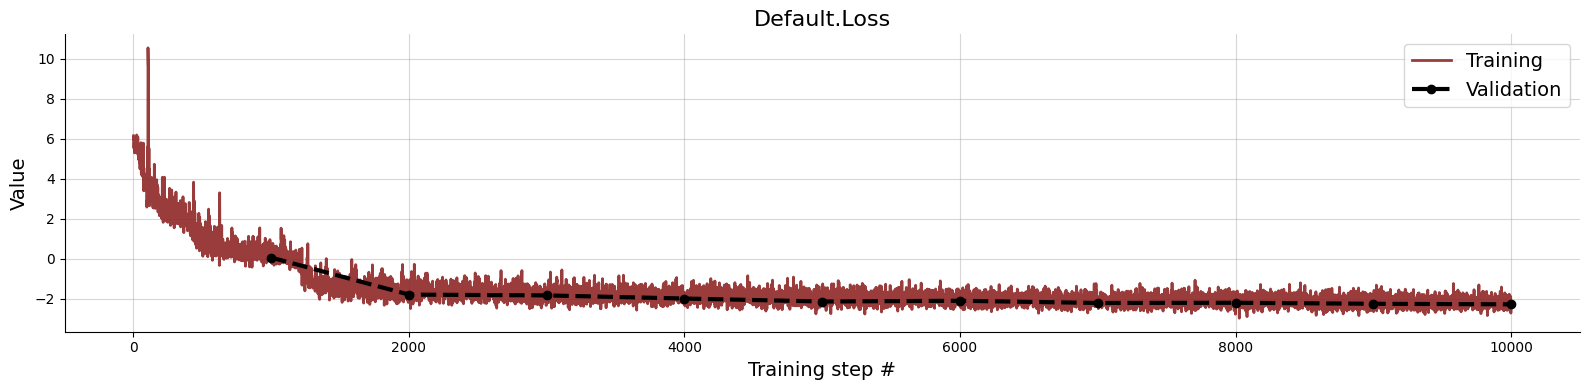

In [30]:
f = bf.diagnostics.plot_losses(
    history["train_losses"], history["val_losses"], moving_average=True
)

### Validating Consistency <a class="anchor" id="validating_consistency"></a>
Validating the consistency of our model-amortizer coupling is an important step which should be performed before any real data are presented to the networks. In other words, the model should work in the ''small world'', before going out in the world of real data. This involves testing the model under known conditions and ensuring that it behaves logically and accurately. It is a critical step to avoid surprises when the model is later exposed to real and more complex data. In addition to a smooth loss reduction curve, we can use at least four handy diagnostic utilities. 

For a better illustration, we will start by generating some test simulations (not seen during training) using the simulator `model`. Note, that we also use the default configurator to prepare these test simulations for interacting with the networks.

In [31]:
test_sims = trainer.configurator(model(500))

#### Latent space inspection <a class="anchor" id="latent_space_inspection"></a>

Since our training objective prescribes a unit Gaussian to the latent variable $\boldsymbol{z}$ (see: https://arxiv.org/abs/2003.06281), we expect that, upon good convergence, the latent space will exhibit the prescribed probabilistic structure. Good convergence means that the model has learned an appropriate representation of the data in its latent space. We can quickly inspect this structure by calling the ``plot_latent_space_2d`` function from the `diagnostics` module. 

In [32]:
z_samples, _ = amortizer(test_sims)

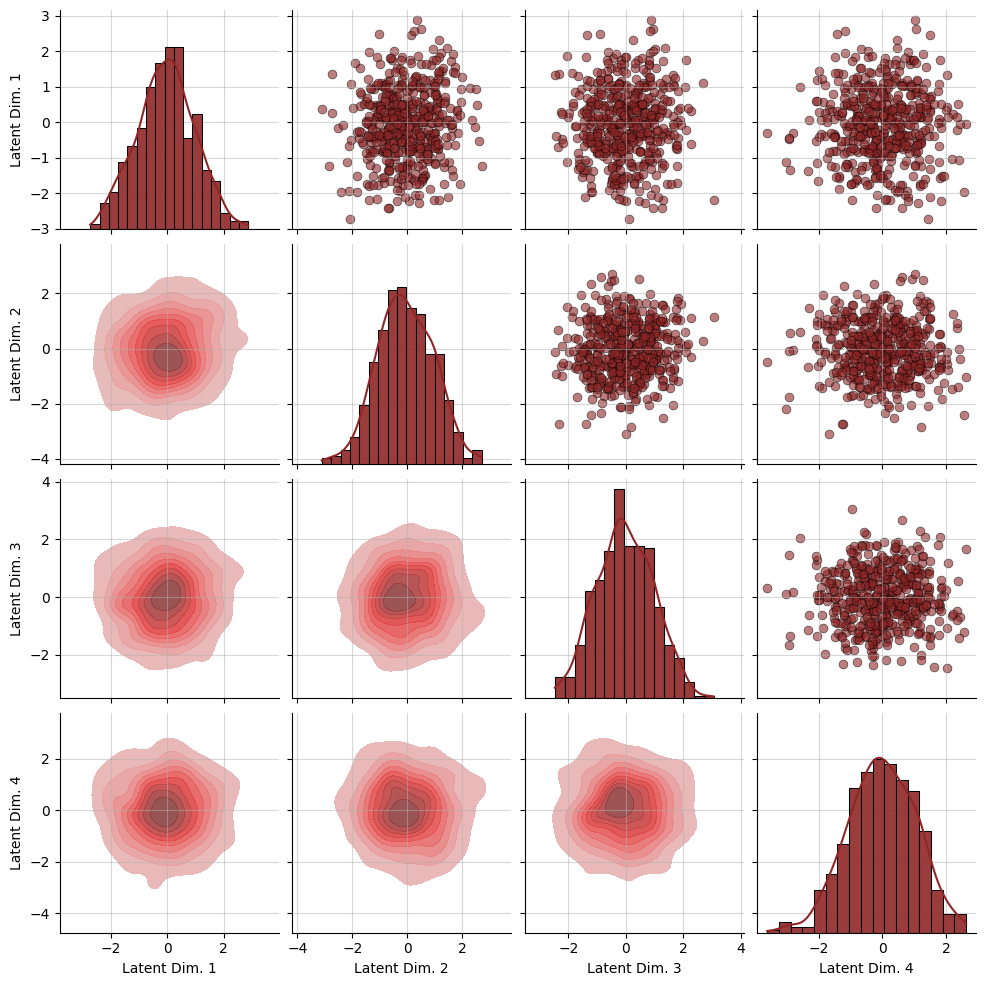

In [33]:
f = bf.diagnostics.plot_latent_space_2d(z_samples)

#### Simulation-Based Calibration <a class="anchor" id="simulation_based_calibration"></a>
By now a classic in Bayesian analysis. If you are not familiar with this procedure, you must read about it here: https://arxiv.org/abs/1804.06788

SBC is a technique used to assess whether a probabilistic model correctly infers parameters from data. The basic idea is to simulate a large number of datasets from the model's prior distribution and then perform posterior inference on these simulated datasets. The goal is to check if the inferred posterior distributions are consistent with the priors. Essentially, SBC tests if the model can accurately recover the parameters it used to generate the data in the first place. This process helps identify any systematic biases or inaccuracies in the model's inference process.

To perform SBC, we first need to obtain `L` number of posterior draws from `M` simulated data sets. While the procedure is typically intractable, amortized inference allows us to perform SBC instantly.

In [34]:
# Obtain 100 posterior samples for each simulated data set in test_sims
posterior_samples = amortizer.sample(test_sims, n_samples=100)

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 5.                    Confidence intervals might be unreliable!


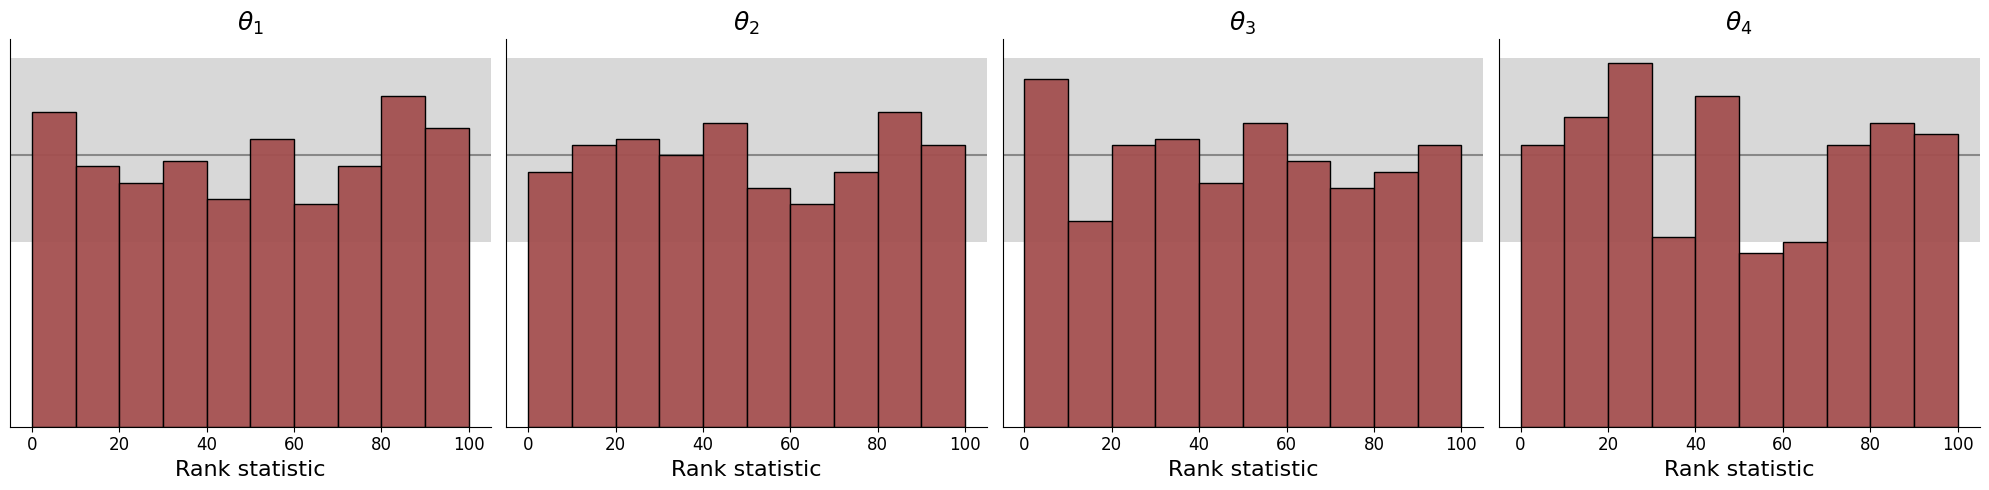

In [35]:
f = bf.diagnostics.plot_sbc_histograms(
    posterior_samples, test_sims["parameters"], num_bins=10
)

Note, that the above function complains about the simulations-to-posterior-samples ratio, which is too low for reasonable density estimation and confidence intervals. Thus, we may want to use the more modern version of SBC which is based on empirical cumulative distribution functions (ECDFs) and does not have a `num_bins` hyperparameter. You can read more about this method at https://arxiv.org/abs/2103.10522.

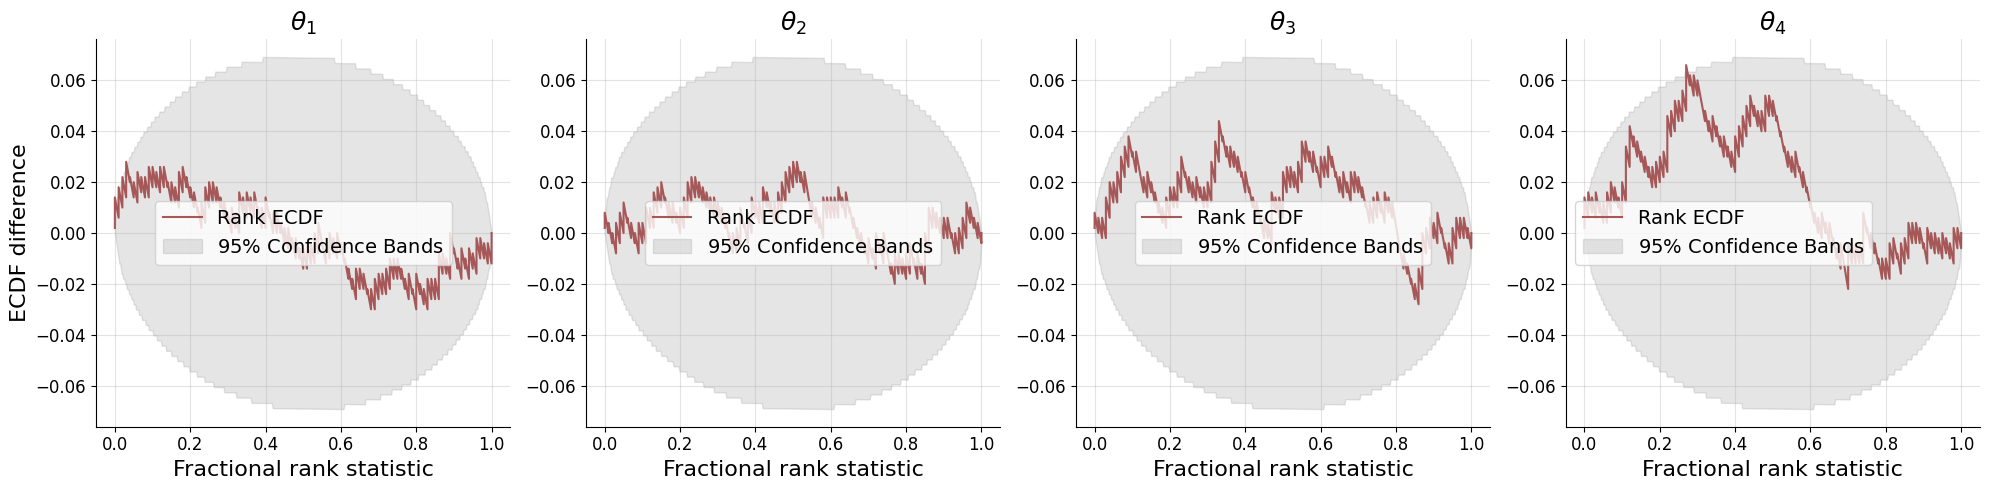

In [36]:
f = bf.diagnostics.plot_sbc_ecdf(
    posterior_samples, test_sims["parameters"], difference=True
)

#### Posterior z-score and contraction <a class="anchor" id="posterior_z_score_and"></a>

* Posterior z-score: It measures how many standard deviations away the mean of the posterior distribution is from the true value of the parameter. A z-score of 0 indicates the mean perfectly aligns with the true value (no bias) while positive/negative z-scores indicate positive/negative bias, respectively.
* Posterior contraction: It measures how much the posterior distribution contracts around the true value of the parameter as more data is observed. A higher contraction indicates that the data provides strong evidence, narrowing the uncertainty range.

Ideally, we should obtain high contraction and a z-score near 0. This means the model accurately captures the true value with little bias and high confidence.

A quick and dirty way to gain an understanding of how good point estimates and uncertainty estimates capture the "true" parameters, assuming the generative model is well-specified. For this, we will draw more samples from the posteriors in order to get smaller Monte Carlo error.

In [37]:
post_samples = amortizer.sample(test_sims, n_samples=1000)

Note the shapes of our resulting array: `(500, 1000, 4)`. The resulting array holds the $1000$ posterior draws (axis 1) for each of the $500$ data sets (axis 0). The final axis (axis 2) represents the number of target parameters.

In [38]:
print("Shape of posterior samples array:", post_samples.shape)

Shape of posterior samples array: (500, 1000, 4)


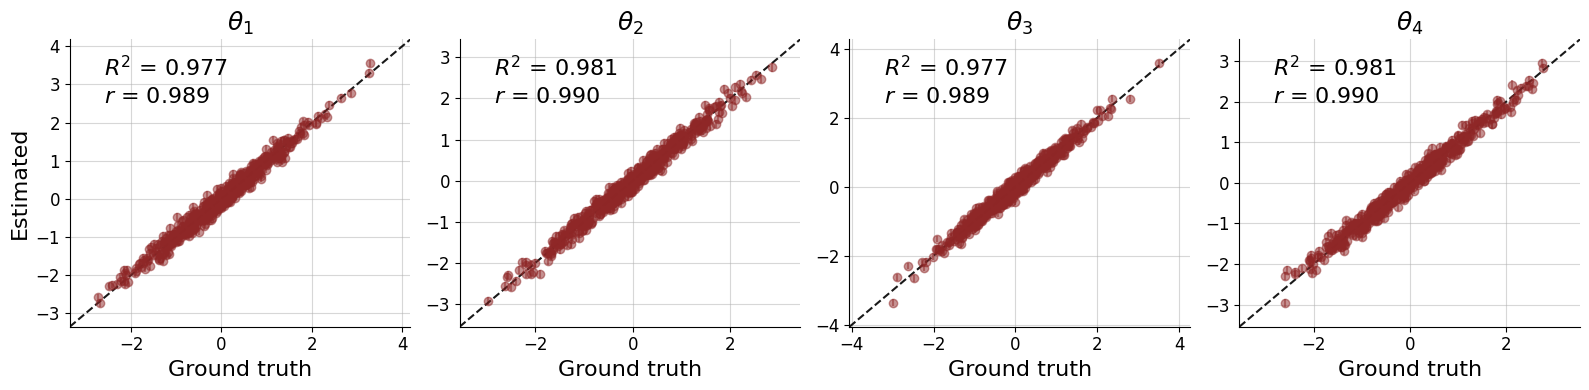

In [39]:
f = bf.diagnostics.plot_recovery(post_samples, test_sims["parameters"])

Even better, you might want to inspect the sensitivity of the model in terms of how good some expectation (e.g., the mean) captures the ground truth parameter and how much the posterior shrinks with regard to the prior (i.e., so called posterior contraction). For that, we can compute the prior variance analytically or simply estimate it via Monte Carlo.

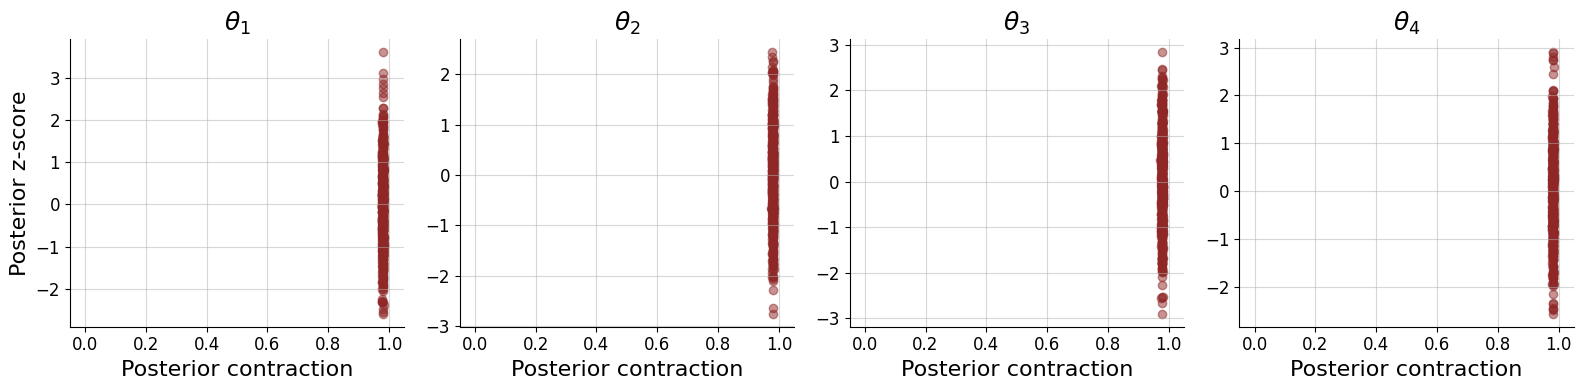

In [40]:
f = bf.diagnostics.plot_z_score_contraction(
    post_samples, test_sims["parameters"]
)

We observe the best case of model adequacy - no bias and large contraction. You can play around with different samples sizes per simulation (i.e., the `n_obs` argument in the likelihood function) and check all diagnostics again. Or, even better, you can try estimating your own models!

## Inference Phase <a class="anchor" id="inference_phase"></a>
Once the approximator has passed all consistency checks, we can now go ahead and apply it to real data! Since the data-generating parameters of real systems are per definition unobservable, we cannot use the same methods as below for ascertaining real-world validity of our inferences. Hence, as in any modeling scenario, we would need external validation and posterior predictive checks.

In [48]:
# Your code here
test_sims.keys()

dict_keys(['summary_conditions', 'direct_conditions', 'parameters'])

In [57]:
test_sims["parameters"].shape

(500, 4)